# Pytorch Datasets

Goal: Setting up pytorch with the datasets so it will train to identify a dog or cat

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import random

# for visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [17]:
device = torch.device("cpu")
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

mps


### Creating Animals Class for pytorch to access

In [18]:
class AnimalsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
       self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes    

In [28]:
dir = '../data/dataset/training_set'
test = '../data/dataset/test_set'
dataset = AnimalsDataset(dir)
len(dataset)

target_to_class = {v: k for k, v in ImageFolder(dir).class_to_idx.items()}
print(target_to_class)

{0: 'cats', 1: 'dogs'}


In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    ),
])
dataset = AnimalsDataset(dir, transform=transform)
i, l = dataset[2]
i.shape

testset = AnimalsDataset(test, transform=transform)

 ### Creating a dataloader

In [61]:
trainloader = DataLoader(dataset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)
print(trainloader)
classes = ('cat', 'dog')

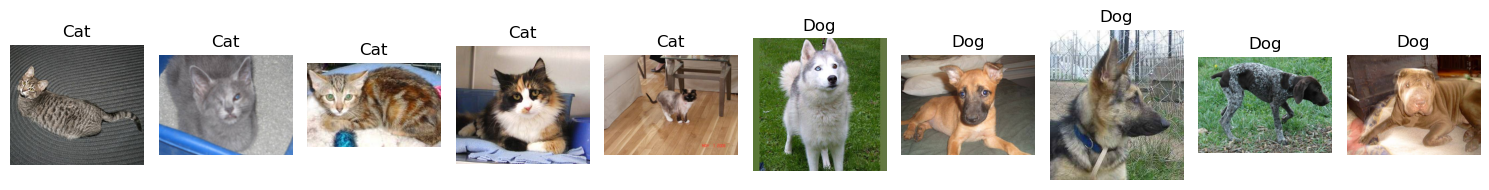

In [46]:

cat_class_idx = classes.index("cat")  
dog_class_idx = classes.index("dog") 

fig, axes = plt.subplots(1, 10, figsize=(15, 5)) 

cat_count, dog_count = 0, 0
max_images_per_class = 5  


for i in range(10):
    while cat_count < max_images_per_class or dog_count < max_images_per_class:
        rand = random.randint(0, len(trainloader.dataset) - 1)  
        image, label = trainloader.dataset[rand] 
        
        if label == cat_class_idx and cat_count < max_images_per_class:
            image = image.permute(1, 2, 0) 
            denormalized_image = image / 2 + 0.5  
            axes[cat_count].imshow(denormalized_image)
            axes[cat_count].set_title("Cat")
            axes[cat_count].axis('off')
            cat_count += 1
            break

        elif label == dog_class_idx and dog_count < max_images_per_class:
            image = image.permute(1, 2, 0) 
            denormalized_image = image / 2 + 0.5  
            axes[5 + dog_count].imshow(denormalized_image)
            axes[5 + dog_count].set_title("Dog")
            axes[5 + dog_count].axis('off')
            dog_count += 1
            break

plt.tight_layout()
plt.show()


# Creating Pytorch Model

In [54]:
class AnimalClassifer(nn.Module):
    def __init__(self, num_classes=2):
        super(AnimalClassifer, self).__init__()
        self.base_model = timm.create_model('resnet18', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        outputs_size = 1000
        # Classifier
        self.classifier = nn.Linear(outputs_size, num_classes)
    def forward(self, x):
        x = self.features(x)
        out  = self.classifier(x)
        return out
   



In [63]:
train_model = AnimalClassifer(num_classes=2)
